# Dynamic RNN Make Pratical

Modify from this [notebook](https://www.kaggle.com/winternguyen/predict-household-electric-power-using-lstms)

Download the dataset from this [link](https://www.kaggle.com/uciml/electric-power-consumption-data-set) and put this dataset under the `dataset` folder.

# Introduction:

In this Notebook, I try to learn and build the Long Short-Term Memory (LSTM) recurrent neural network to fit one third of data and then predict the rest of data.
    
Database information:
    
(1) date: Date in format dd/mm/yyyy

(2) time: time in format hh:mm:ss

(3) global_active_power: household global minute-averaged active power (in kilowatt)

(4) global_reactive_power: household global minute-averaged reactive power (in kilowatt)

(5) voltage: minute-averaged voltage (in volt)

(6) global_intensity: household global minute-averaged current intensity (in ampere)

(7) sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

(8) sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

(9) sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset/household_power_consumption.txt


# Import & cleaning data

Importing the txt file takes more time than that of csv file.

In [2]:
# You can modify the path of the dataset as you need
df = pd.read_csv('dataset/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.shape

(2075259, 7)

This database have 2,075,259 rows and 7 columns. Let's check the NA data and fill na data with the mean values.

In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# Data Preparation and fitting

The LSTM nueral network has been selected because:

+ it is best suited for large data, 
+ time-seriers, and 
+ sequential problem.

In the first step, I will fram the problem to predict the Global_active_power.

In [6]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In order to reduce the computation time, and also get a quick result to test the model. We have resampled the data over hour to reduce the size of data from 2075259 to 34589 (data are given in minutes).

In [8]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

So, we will have 7 input series variables and the 1 output variable for 'Global_active_power' at the current time in hour.

We also splitting the data into: train and validation sets. I select 4000 data over 34,589 dat to train, the rest will be used to test the model.

In [9]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.144652,0.0,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.030869,0.0,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.000000,0.0,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.008973,0.0,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.002872,0.0,0.205723,0.455597


In [10]:
# Set the Length of Sequence
seq_len = 200

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n = values.shape[0]
seq_num = n // seq_len
series_n = seq_num * seq_len
print(f"N: {n}, Seq Num: {seq_num}, Seq Len: {seq_len}, Series N: {series_n}")
values_truncated = values[:series_n]

n_train_time = 4000
train = values_truncated[:n_train_time, :]
test = values_truncated[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# Shape: [number of sequences, sequence lengh, feature size]
train_x = train_x.reshape((train_x.shape[0] // seq_len, seq_len, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0] // seq_len, seq_len, test_x.shape[1]))
train_y = train_y.reshape((train_y.shape[0] // seq_len, seq_len))
test_y = test_y.reshape((test_y.shape[0] // seq_len, seq_len))

N: 34588, Seq Num: 172, Seq Len: 200, Series N: 34400


In [11]:
print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}')
print(f'test_y shape: {test_y.shape}')

train_x shape: (20, 200, 7)
train_y shape: (20, 200)
test_x shape: (152, 200, 7)
test_y shape: (152, 200)


<h3> LSTM model setting <h3>

(1) 100 neurons in the first visible layer

(2) dropout 10%

(3) 1 neuron in the output layer for predicting Global_active_power

(4) The input shape will be 1 time step with 7 features

(5) The mean_squared_error loss function and the efficient adam version of stochastic gradient descent

(6) The model will be fit for 50 training epochs with a batch size of 70.

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, RNN, Input
from tensorflow.nn import relu

import tensorflow.keras as keras

from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

4 Physical GPUs, 1 Logical GPU


2021-12-02 12:43:48.461792: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 12:43:48.911676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9661 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5


In [13]:
%load_ext tensorboard

# Vanilla RNN

In [14]:
class VanillaRNNCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(VanillaRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.tensordot(inputs, self.kernel, axes=1)
        output = h + tf.tensordot(prev_output, self.recurrent_kernel, axes=1)
        return output, [output]
    
def getVanillaRNN(inputShape):
    rnnLayer = RNN(VanillaRNNCell(100), dynamic=True, return_sequences=True, return_state=False)

    inputs = Input(shape=inputShape)
    x = rnnLayer(inputs)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model

# Single Unit Dynamic RNN
Howeve, since the hidden state contains only 1 unit, the capacity is limited. The performance is quite poor.

In [15]:
# SIngle unit output RNN
class SingleUnitDynamicRNNCell(keras.layers.Layer):
    def __init__(self, units, rnn_units=100, memory_size=3, **kwargs):
        super(SingleUnitDynamicRNNCell, self).__init__(**kwargs)
        # Must have variables
        self.units = units
        self.state_size = tf.TensorShape([memory_size, units])

        # Custom variables
        self.rnn_units = rnn_units
        self.memory_size = memory_size

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.rnn_units),
            initializer='uniform',
            name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.rnn_units),
            initializer='uniform',
            name='recurrent_kernel')
        self.scalar_dense = self.add_weight(
            shape=(self.rnn_units, self.units),
            initializer='uniform',
            name='scalar_dense')
        self.built = True
    
    def generate_indice(self, states):
        batch_size = states.shape[0]
        # Random select
        return tf.random.uniform((batch_size, 1), minval=0, maxval=self.memory_size, dtype=tf.dtypes.int32)

    def select_memory(self, states):
        batch_size = states.shape[0]
        indice = self.generate_indice(states)

        # The sequence number for Indices
        sequence = tf.range(start=0, limit=batch_size)
        sequence = tf.reshape(sequence, (sequence.shape[0], 1))

        # Indices for gather_nd
        gather_indice = tf.concat([sequence, indice], axis=1)

        # Grab the selected datas according to the indice
        selected_state = tf.gather_nd(states, gather_indice)
        return selected_state

    def call(self, inputs, states):
        prev_output = states[0]

        # Recurrent NN
        h = tf.tensordot(inputs, self.kernel, axes=1)
        selected_state = self.select_memory(states[0])
        x = relu(h + tf.tensordot(selected_state, self.recurrent_kernel, axes=1))
        output = tf.tensordot(x, self.scalar_dense, axes=1)

        # Concat new state
        new_state = tf.reshape(output, (output.shape[0], 1, output.shape[1]))
        output_states = tf.concat([new_state, prev_output], axis=1)
        output_states = output_states[:, 0:self.memory_size, :]

        return output, [output_states]

def getSingleUnitRNN(inputShape, memory_size):
    rnnLayer = RNN(SingleUnitDynamicRNNCell(1, rnn_units=100, memory_size=memory_size), dynamic=True, return_sequences=True, return_state=False)

    inputs = Input(shape=inputShape)
    outputs = rnnLayer(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model

# Multi-Units Dynamic RNN

In [16]:
class DynamicRNNCell(keras.layers.Layer):
    def __init__(self, units, memory_size=3, **kwargs):
        super(DynamicRNNCell, self).__init__(**kwargs)
        # Must have variables
        self.units = units
        self.state_size = tf.TensorShape([memory_size, units])

        # Custom variables
        self.memory_size = memory_size

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True
    
    def generate_indice(self, states):
        batch_size = states.shape[0]
        # Random select
        return tf.random.uniform((batch_size, 1), minval=0, maxval=self.memory_size, dtype=tf.dtypes.int32)

    def select_memory(self, states):
        batch_size = states.shape[0]
        indice = self.generate_indice(states)

        # The sequence number for Indices
        sequence = tf.range(start=0, limit=batch_size)
        sequence = tf.reshape(sequence, (sequence.shape[0], 1))

        # Indices for gather_nd
        gather_indice = tf.concat([sequence, indice], axis=1)

        # Grab the selected datas according to the indice
        selected_state = tf.gather_nd(states, gather_indice)
        return selected_state

    def call(self, inputs, states):
        prev_output = states[0]

        # Recurrent NN
        h = tf.tensordot(inputs, self.kernel, axes=1)
        selected_state = self.select_memory(states[0])
        output = h + tf.tensordot(selected_state, self.recurrent_kernel, axes=1)

        # Concat new state
        new_state = tf.reshape(output, (output.shape[0], 1, output.shape[1]))
        output_states = tf.concat([new_state, prev_output], axis=1)
        output_states = output_states[:, 0:self.memory_size, :]

        return output, [output_states]

def getModel(inputShape, memory_size):
    rnnLayer = RNN(DynamicRNNCell(100, memory_size=memory_size), dynamic=True, return_sequences=True, return_state=False)

    inputs = Input(shape=inputShape)
    x = rnnLayer(inputs)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 7)]          0         
_________________________________________________________________
rnn (RNN)                    (None, 200, 3, 100)       0 (unused)
_________________________________________________________________
dropout (Dropout)            (None, 200, 3, 100)       0         
_________________________________________________________________
dense (Dense)                (None, 200, 3, 1)         101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2021-12-02 12:43:49.667627: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-02 12:43:49.667695: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-02 12:43:49.667816: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 4 GPUs
2021-12-02 12:43:49.668567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:/usr/local/cuda-11.2/lib64:/usr/local/lib64:/usr/local/cuda-11.2/lib64:
2021-12-02 12:43:49.668816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:/usr/local/cuda-11.2/lib64:/usr/local/lib64:/usr/local/cuda-11.2/lib64:
202

1/1 - 2s - loss: 0.0535 - val_loss: 0.0243
Epoch 2/20


2021-12-02 12:43:51.466163: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-02 12:43:51.466201: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-02 12:43:51.466676: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-02 12:43:51.915334: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-02 12:43:51.916135: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-02 12:43:51.972210: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-02 12:43:52.020479: I tensorflow

1/1 - 2s - loss: 0.0412 - val_loss: 0.0174
Epoch 3/20
1/1 - 1s - loss: 0.0310 - val_loss: 0.0129
Epoch 4/20
1/1 - 1s - loss: 0.0230 - val_loss: 0.0114
Epoch 5/20
1/1 - 1s - loss: 0.0177 - val_loss: 0.0135
Epoch 6/20
1/1 - 1s - loss: 0.0157 - val_loss: 0.0181
Epoch 7/20
1/1 - 1s - loss: 0.0172 - val_loss: 0.0211
Epoch 8/20
1/1 - 1s - loss: 0.0185 - val_loss: 0.0209
Epoch 9/20
1/1 - 1s - loss: 0.0182 - val_loss: 0.0183
Epoch 10/20
1/1 - 1s - loss: 0.0166 - val_loss: 0.0153
Epoch 11/20
1/1 - 1s - loss: 0.0148 - val_loss: 0.0126
Epoch 12/20
1/1 - 1s - loss: 0.0130 - val_loss: 0.0107
Epoch 13/20
1/1 - 1s - loss: 0.0121 - val_loss: 0.0093
Epoch 14/20
1/1 - 1s - loss: 0.0117 - val_loss: 0.0085
Epoch 15/20
1/1 - 1s - loss: 0.0117 - val_loss: 0.0081
Epoch 16/20
1/1 - 1s - loss: 0.0115 - val_loss: 0.0079
Epoch 17/20
1/1 - 1s - loss: 0.0114 - val_loss: 0.0077
Epoch 18/20
1/1 - 1s - loss: 0.0117 - val_loss: 0.0076
Epoch 19/20
1/1 - 1s - loss: 0.0114 - val_loss: 0.0075
Epoch 20/20
1/1 - 1s - loss: 

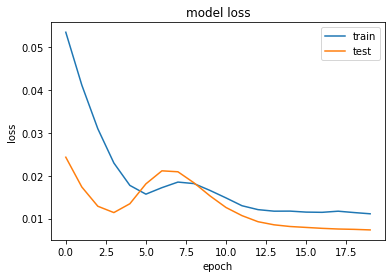

In [17]:
import datetime

batch_size = 70
memory_size = 3

# model = getVanillaRNN((train_x.shape[1], train_x.shape[2]))
model = getModel((train_x.shape[1], train_x.shape[2]), memory_size=memory_size)
# model = getSingleUnitRNN((train_x.shape[1], train_x.shape[2]), memory_size=memory_size)

# Network fitting
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(train_x, train_y, 
                    epochs=20, batch_size=batch_size, 
                    validation_data=(test_x, test_y), verbose=2, 
                    callbacks=[tensorboard_callback])

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.

(30400, 1)
(30400, 7)
Test RMSE: 0.553


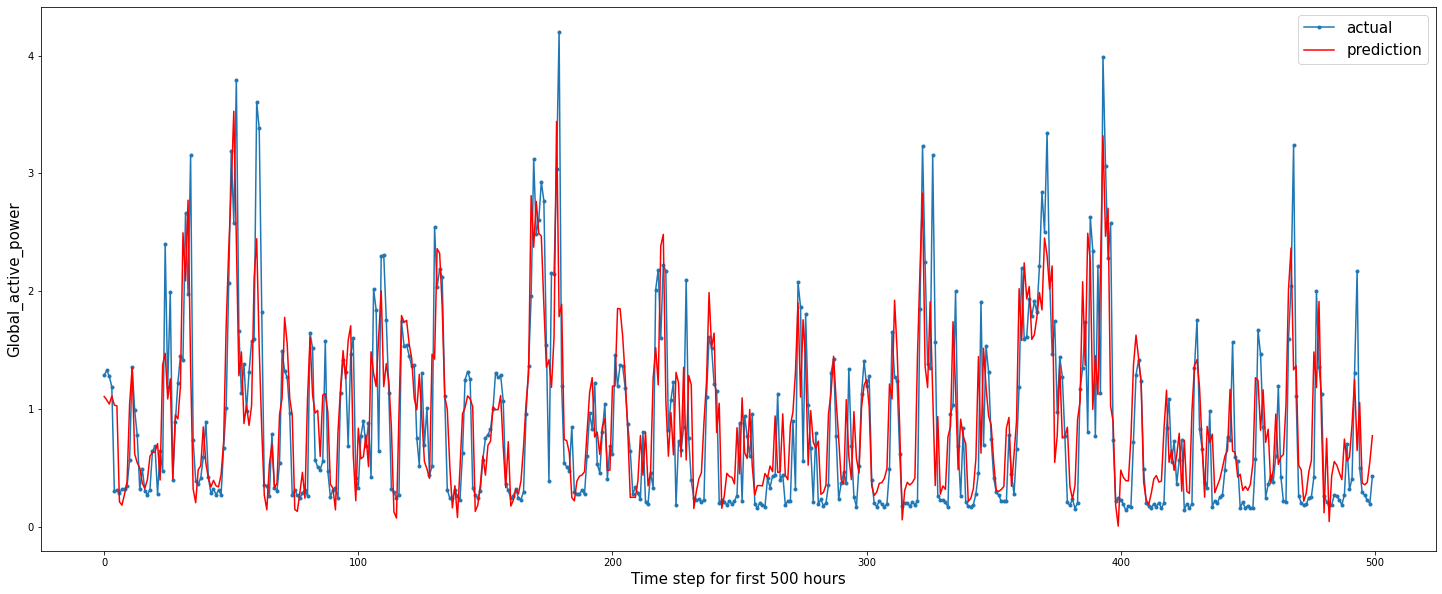

In [18]:
size = test_x.shape[2]

# Prediction test
yhat = model.predict(test_x)
yhat = yhat.reshape((-1, 1))
print(yhat.shape)
test_x_reshape = test_x.reshape((-1, size))
print(test_x_reshape.shape)

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x_reshape[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshape = test_y.reshape(-1, 1)
inv_y = np.concatenate((test_y_reshape, test_x_reshape[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

# Reference

Tensorflow 2.0 APIs
- [tf.range](https://www.tensorflow.org/api_docs/python/tf/range)
- [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd)
- [tf.keras.layers.RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
  - Also contain the example code of `return_sequences` and `return_state`
- [tf.tensordot](https://www.tensorflow.org/api_docs/python/tf/tensordot)
- [Introduction to tensor slicing](https://www.tensorflow.org/guide/tensor_slicing)